<a href="https://colab.research.google.com/github/jumadi-cloud/segmentasi_cancer/blob/main/New_1_(accuracy_97)_CNN_Pap_smear_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification menggunakan CNN

Refrensi

https://www.kaggle.com/code/hannahkariuki/cnn-for-retinal-oct-images

In [ ]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
# Reproducibility
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
!pip install gdown

In [ ]:
# import gdown

# file_id = "15o5ahcavPUlOn5ZObQF16-MPtdAU2en8"  # Replace this with your file's ID
# output_file = "PapSmear1.zip"  # Replace "data_file.ext" with the desired output filename and extension

# gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

In [ ]:
import gdown

file_id = "1-bfrFLD5lKPGvy3eCjjUvjLMVYRFwgKV"  # Replace this with your file's ID
output_file = "PapSmear.zip"  # Replace "data_file.ext" with the desired output filename and extension

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1-bfrFLD5lKPGvy3eCjjUvjLMVYRFwgKV
To: /content/PapSmear.zip
100%|██████████| 438M/438M [00:08<00:00, 49.7MB/s]


'PapSmear.zip'

In [ ]:
import zipfile
with zipfile.ZipFile("/content/PapSmear.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [ ]:
# import zipfile
# with zipfile.ZipFile("/content/PapSmear1.zip", 'r') as zip_ref:
#     zip_ref.extractall("./")

In [ ]:
train_directory = '/content/PapSmear/train update'
test_directory = '/content/PapSmear/valid'

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    seed=0,
    image_size=(128,128),
    batch_size=16,
    color_mode='rgb',
    validation_split= 0.2,
    subset='training'
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    seed=0,
    image_size=(128,128),
    batch_size=16,
    color_mode='rgb',
    validation_split=0.2,
    subset='validation'
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    image_size=(128,128),
    batch_size=16,
    color_mode='rgb',
)

Found 18917 files belonging to 4 classes.
Using 15134 files for training.
Found 18917 files belonging to 4 classes.
Using 3783 files for validation.
Found 400 files belonging to 4 classes.


In [ ]:
class_labels= ['Sel Normal', 'L-Sil','H-Sil','Sel Koilocyt']

In [ ]:
#store test labels
test_labels = [labels for _, labels in test.unbatch()]

In [ ]:
# Classes
class_names=train.class_names
print(class_names)

['H-Sil', 'L-Sil', 'Sel Koilocyt', 'Sel Normal']


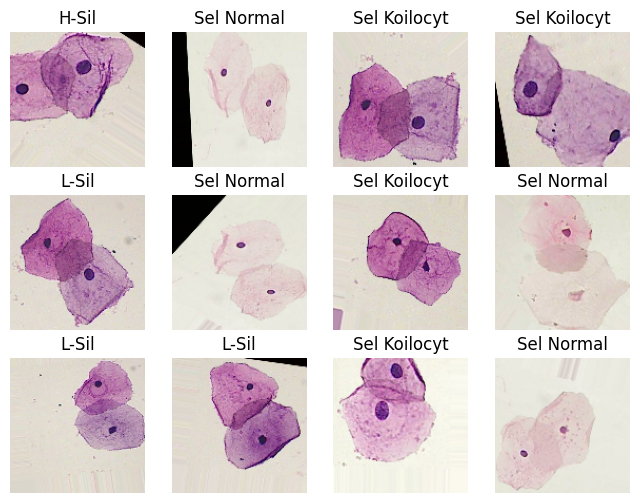

In [ ]:
# visualize some of the images
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Determine the distribution of classes
BATCH_SIZE=16
class_names = train.class_names

def class_distribution(dataset):
    class_values = []
    total_batches = dataset.__len__().numpy()
    for batch, element in enumerate(dataset.as_numpy_iterator()):
        if batch+1 == total_batches:
            for i in range(len(element[1])):
                class_values.append(class_names[int(element[1][i])])
        else:
            for i in range(BATCH_SIZE):
                class_values.append(class_names[int(element[1][i])])

    class_n, frequency = np.unique(np.array(class_values), return_counts=True)
    #frequency = frequency/len(class_values)
    return pd.DataFrame(frequency, class_n, columns=["Count"])

train_class_dist = class_distribution(train)
print(train_class_dist)

              Count
H-Sil          2501
L-Sil          2467
Sel Koilocyt   2637
Sel Normal     7529


In [ ]:
#Calculate class weight
total = len(train.file_paths)
count_cnv = 29709
count_dme = 9113
count_drusen = 6917
count_normal = 21049
cnv_weight = (1/count_cnv) * (total/4)
dme_weight = (1/count_dme) * (total/4)
drusen_weight = (1/count_drusen) * (total/4)
norm_weight = (1/count_normal) * (total/4)
class_weight = {0 : cnv_weight, 1: dme_weight, 2 : drusen_weight, 3: norm_weight}
print(class_weight)

{0: 0.12735198088121444, 1: 0.415176122023483, 2: 0.54698568743675, 3: 0.1797472564017293}


In [ ]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (
    train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
validation = (
    validation
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test = (
    test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',input_shape=(128,128,3)),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(units=4, activation='sigmoid'),
])

In [ ]:
optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001)

In [ ]:
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 150,
    shuffle=True,
)

Epoch 1/150
946/946 [==============================] - 36s 36ms/step - loss: 0.1540 - accuracy: 0.7401 - val_loss: 0.5374 - val_accuracy: 0.7433
Epoch 2/150
946/946 [==============================] - 34s 35ms/step - loss: 0.1534 - accuracy: 0.7414 - val_loss: 0.5360 - val_accuracy: 0.7462
Epoch 3/150
946/946 [==============================] - 33s 35ms/step - loss: 0.1528 - accuracy: 0.7424 - val_loss: 0.5352 - val_accuracy: 0.7465
Epoch 4/150
946/946 [==============================] - 33s 35ms/step - loss: 0.1521 - accuracy: 0.7434 - val_loss: 0.5344 - val_accuracy: 0.7481
Epoch 5/150
946/946 [==============================] - 33s 35ms/step - loss: 0.1516 - accuracy: 0.7439 - val_loss: 0.5333 - val_accuracy: 0.7497
Epoch 6/150
946/946 [==============================] - 34s 35ms/step - loss: 0.1510 - accuracy: 0.7448 - val_loss: 0.5325 - val_accuracy: 0.7510
Epoch 7/150
946/946 [==============================] - 33s 35ms/step - loss: 0.1504 - accuracy: 0.7454 - val_loss: 0.5315 - val_ac

Best Validation Loss: 0.5115
Best Validation Accuracy: 0.7602


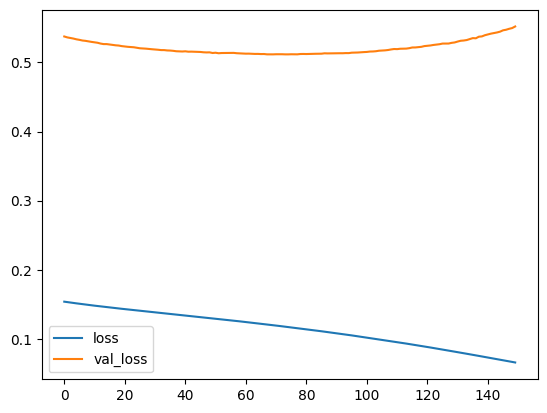

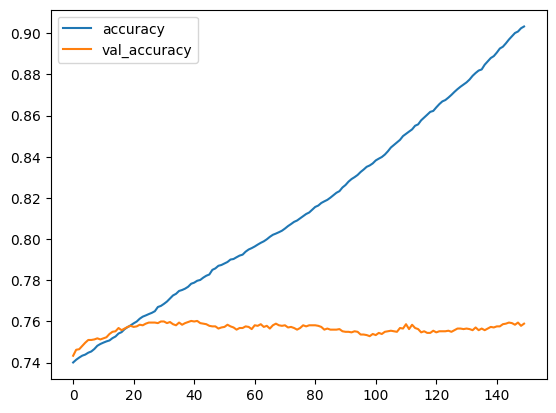

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_accuracy'].max()))

In [ ]:
model.evaluate(test, return_dict=True)

25/25 [==============================] - 1s 29ms/step - loss: 4.0370 - accuracy: 0.3325


{'loss': 4.037005424499512, 'accuracy': 0.33250001072883606}

In [ ]:
predictions = model.predict(test)
#Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

25/25 [==============================] - 0s 11ms/step


In [ ]:
#get classification report
print(classification_report(predictions, test_labels, target_names=class_labels))

              precision    recall  f1-score   support

  Sel Normal       0.27      0.25      0.26       108
       L-Sil       0.03      0.14      0.05        22
       H-Sil       0.12      0.21      0.15        57
Sel Koilocyt       0.54      0.25      0.35       213

    accuracy                           0.24       400
   macro avg       0.24      0.21      0.20       400
weighted avg       0.38      0.24      0.28       400



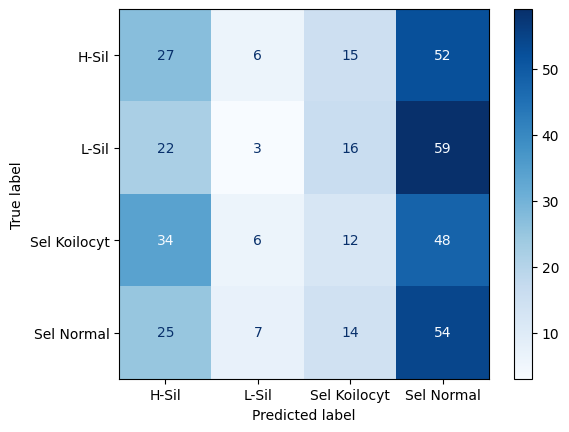

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Tran ulang

In [ ]:
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 50,
    shuffle=True,
)

Epoch 1/50
946/946 [==============================] - 34s 35ms/step - loss: 0.0653 - accuracy: 0.9057 - val_loss: 0.5538 - val_accuracy: 0.7579
Epoch 2/50
946/946 [==============================] - 33s 35ms/step - loss: 0.0646 - accuracy: 0.9076 - val_loss: 0.5544 - val_accuracy: 0.7573
Epoch 3/50
946/946 [==============================] - 34s 36ms/step - loss: 0.0638 - accuracy: 0.9090 - val_loss: 0.5563 - val_accuracy: 0.7576
Epoch 4/50
946/946 [==============================] - 33s 35ms/step - loss: 0.0629 - accuracy: 0.9110 - val_loss: 0.5576 - val_accuracy: 0.7579
Epoch 5/50
946/946 [==============================] - 33s 35ms/step - loss: 0.0621 - accuracy: 0.9122 - val_loss: 0.5589 - val_accuracy: 0.7579
Epoch 6/50
946/946 [==============================] - 33s 35ms/step - loss: 0.0614 - accuracy: 0.9131 - val_loss: 0.5604 - val_accuracy: 0.7568
Epoch 7/50
946/946 [==============================] - 33s 35ms/step - loss: 0.0605 - accuracy: 0.9148 - val_loss: 0.5626 - val_accuracy:

Test 2 menggunakan Normalization and Dropout

In [ ]:
#Adding Batch Normalization and Dropout
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(renorm=True),
    layers.Dropout(0.3),
    layers.Dense(units=4, activation='sigmoid'),
])

In [ ]:
optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001)

In [ ]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 20,
    callbacks=[early_stopping],
    shuffle=True,
)

Epoch 1/20
946/946 [==============================] - 47s 44ms/step - loss: 0.3681 - accuracy: 0.5041 - val_loss: 0.8198 - val_accuracy: 0.6820
Epoch 2/20
946/946 [==============================] - 42s 44ms/step - loss: 0.2479 - accuracy: 0.6511 - val_loss: 0.6987 - val_accuracy: 0.7341
Epoch 3/20
946/946 [==============================] - 42s 44ms/step - loss: 0.2191 - accuracy: 0.6991 - val_loss: 0.6562 - val_accuracy: 0.7576
Epoch 4/20
946/946 [==============================] - 42s 44ms/step - loss: 0.2008 - accuracy: 0.7227 - val_loss: 0.6288 - val_accuracy: 0.7605
Epoch 5/20
946/946 [==============================] - 42s 44ms/step - loss: 0.1923 - accuracy: 0.7358 - val_loss: 0.6213 - val_accuracy: 0.7637
Epoch 6/20
946/946 [==============================] - 41s 44ms/step - loss: 0.1850 - accuracy: 0.7442 - val_loss: 0.6133 - val_accuracy: 0.7655
Epoch 7/20
946/946 [==============================] - 41s 44ms/step - loss: 0.1798 - accuracy: 0.7487 - val_loss: 0.5986 - val_accuracy:

Best Validation Loss: 0.5830
Best Validation Accuracy: 0.7769


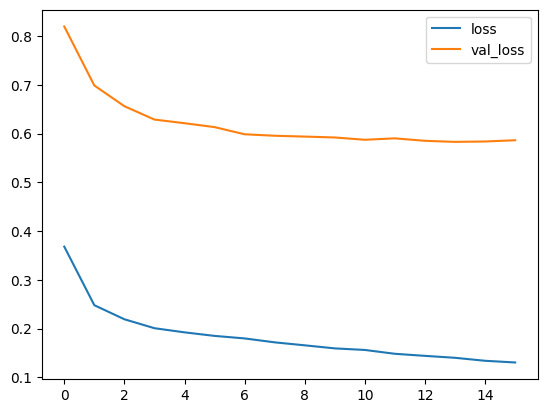

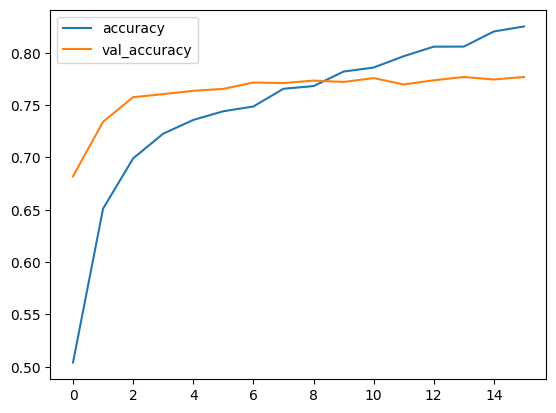

In [ ]:
acc = history.history['accuracy']
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_accuracy'].max()))

In [ ]:
model.evaluate(test, return_dict=True)

25/25 [==============================] - 0s 15ms/step - loss: 1.7790 - accuracy: 0.3250


{'loss': 1.7789779901504517, 'accuracy': 0.32499998807907104}

In [ ]:
predictions = model.predict(test)
#Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

25/25 [==============================] - 0s 10ms/step


In [ ]:
#get classification report
print(classification_report(predictions, test_labels, target_names=class_labels))

              precision    recall  f1-score   support

  Sel Normal       0.11      0.26      0.15        43
       L-Sil       0.17      0.21      0.19        81
       H-Sil       0.41      0.28      0.33       147
Sel Koilocyt       0.32      0.25      0.28       129

    accuracy                           0.25       400
   macro avg       0.25      0.25      0.24       400
weighted avg       0.30      0.25      0.27       400



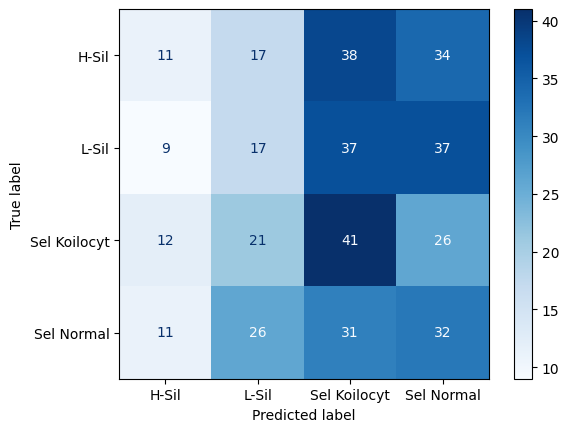

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
#Adding Batch Normalization and Dropout
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(renorm=True),
    layers.Dropout(0.3),
    layers.Dense(units=4, activation='softmax'),
])

In [ ]:
optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.001)

In [ ]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 15,
    callbacks=[early_stopping],
    shuffle=True,
)

Epoch 1/15
946/946 [==============================] - 47s 47ms/step - loss: 0.0267 - accuracy: 0.9712 - val_loss: 0.4465 - val_accuracy: 0.8229
Epoch 2/15
946/946 [==============================] - 42s 44ms/step - loss: 0.0274 - accuracy: 0.9682 - val_loss: 0.4523 - val_accuracy: 0.8247
Epoch 3/15
946/946 [==============================] - 41s 44ms/step - loss: 0.0303 - accuracy: 0.9614 - val_loss: 0.4356 - val_accuracy: 0.8274
Epoch 4/15
946/946 [==============================] - 41s 43ms/step - loss: 0.0276 - accuracy: 0.9665 - val_loss: 0.4528 - val_accuracy: 0.8261
Epoch 5/15
946/946 [==============================] - 41s 43ms/step - loss: 0.0253 - accuracy: 0.9706 - val_loss: 0.4451 - val_accuracy: 0.8261
Epoch 6/15
946/946 [==============================] - 41s 44ms/step - loss: 0.0236 - accuracy: 0.9736 - val_loss: 0.4509 - val_accuracy: 0.8290
Epoch 7/15
946/946 [==============================] - 42s 44ms/step - loss: 0.0224 - accuracy: 0.9769 - val_loss: 0.4509 - val_accuracy:

Best Validation Loss: 0.4461
Best Validation Accuracy: 0.8250


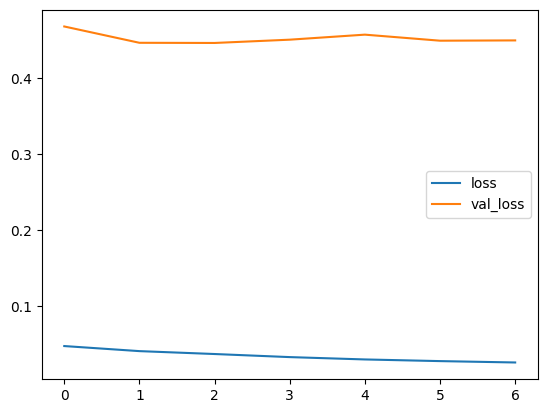

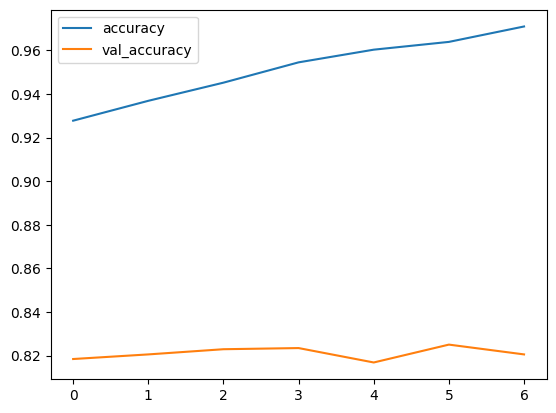

In [ ]:
acc = history.history['accuracy']
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_accuracy'].max()))

In [ ]:
model.evaluate(test, return_dict=True)

25/25 [==============================] - 0s 14ms/step - loss: 2.4806 - accuracy: 0.2950


{'loss': 2.480600357055664, 'accuracy': 0.29499998688697815}

In [ ]:
predictions = model.predict(test)
#Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

25/25 [==============================] - 0s 13ms/step


In [ ]:
#get classification report
print(classification_report(predictions, test_labels, target_names=class_labels))

              precision    recall  f1-score   support

  Sel Normal       0.05      0.16      0.08        31
       L-Sil       0.27      0.23      0.25       116
       H-Sil       0.32      0.27      0.29       118
Sel Koilocyt       0.35      0.26      0.30       135

    accuracy                           0.25       400
   macro avg       0.25      0.23      0.23       400
weighted avg       0.29      0.25      0.27       400



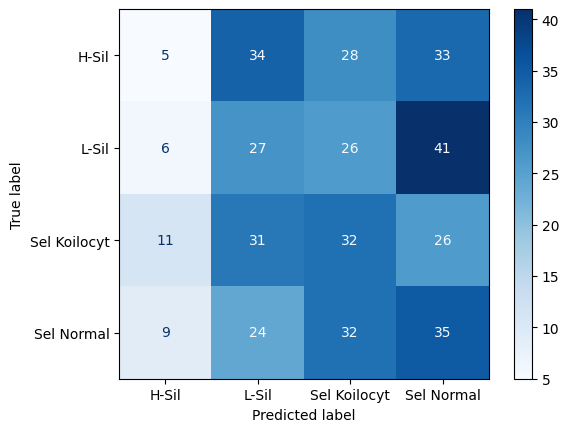

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Refrensi

https://www.kaggle.com/code/hannahkariuki/cnn-for-retinal-oct-images

New

In [ ]:
# import gdown

# file_id = "1-bfrFLD5lKPGvy3eCjjUvjLMVYRFwgKV"  # Replace this with your file's ID
# output_file = "PapSmear.zip"  # Replace "data_file.ext" with the desired output filename and extension

# gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1-bfrFLD5lKPGvy3eCjjUvjLMVYRFwgKV
To: /content/PapSmear.zip
100%|██████████| 438M/438M [00:02<00:00, 160MB/s]


'PapSmear.zip'

In [ ]:
# import zipfile
# with zipfile.ZipFile("/content/PapSmear.zip", 'r') as zip_ref:
#     zip_ref.extractall("./")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Di dalam dataset tersebut, terdapat 3 partisi data yang berbeda. Yaitu data training, validation dan juga testing. Berikut adalah perintah untuk melakukan proses loading gambar-gambar di dataset yang sudah kita ekstrak sebelumnya.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Semua gambar (pixelnya) di rescale menjadi rentang 0-1
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'

# Proses load data train
train_generator = train_datagen.flow_from_directory(
        '/content/PapSmear1/train',  # Source dari data train
        classes = ['Sel Normal', 'L-Sil','H-Sil','Sel Koilocyt'],
        target_size=(500, 500),  # Semua gambar akan diresize menjadi 500x500
        batch_size=16)

# Proses load data validation
validation_generator = validation_datagen.flow_from_directory(
        '/content/PapSmear1/valid',  # Source dari data validation
        classes = ['Sel Normal', 'L-Sil','H-Sil','Sel Koilocyt'],
        target_size=(500, 500),  # Semua gambar akan diresize menjadi 500x500
        batch_size=16,
        shuffle=False)

# Proses load data test
test_generator = test_datagen.flow_from_directory(
        '/content/PapSmear1/test',  # Source dari data test
        classes = ['Sel Normal', 'L-Sil','H-Sil','Sel Koilocyt'],
        target_size=(500, 500),  # Semua gambar akan diresize menjadi 200x200
        batch_size=16,
        shuffle=False)

Found 320 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Setelah dataset berhasil di muat, mari kita lanjutkan ke tahap modelling. Berikut adalah beberapa library yang akan dibutuhkan.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Accuracy
from tensorflow.keras.callbacks import EarlyStopping


Kita akan mencoba arsitektur CNN sebagai berikut.

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(500,500, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 64)        0

Kita akan menggunakan Recall, Precision dan Accuracy untuk bahan evaluasi model.

In [ ]:
from tensorflow.keras.metrics import Recall, Precision

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= [Recall(), Precision(), "accuracy"]
)

Model callback berikut ini digunakan untuk memberhentikan proses training dengan ketentuan jika nilai loss dalam 3 iterasi selanjutnya sudah tidak menurun.

In [ ]:
model_callback = EarlyStopping(
    monitor = 'loss',
    verbose = 1,
    mode = 'min',
    patience= 3
)

Lakukan proses training.

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=2,
    callbacks = [model_callback],
    verbose=1
)

Epoch 1/10
2/2 [==============================] - 22s 2s/step - loss: 3.1637 - recall: 0.0312 - precision: 0.0714 - accuracy: 0.1875 - val_loss: 6.5739 - val_recall: 0.2500 - val_precision: 0.2500 - val_accuracy: 0.2500
Epoch 2/10
2/2 [==============================] - 3s 1s/step - loss: 5.1993 - recall: 0.3125 - precision: 0.3125 - accuracy: 0.3125 - val_loss: 2.8208 - val_recall: 0.2500 - val_precision: 0.2500 - val_accuracy: 0.2500
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 2.7884 - recall: 0.2500 - precision: 0.2857 - accuracy: 0.2500 - val_loss: 1.4100 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.2500
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 1.3542 - recall: 0.0312 - precision: 1.0000 - accuracy: 0.3125 - val_loss: 1.3907 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.0312
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 1.3379 - recall: 0.0000e+00 - precisio

Kita sudah mendapatkan akurasi train dan validation yang cukup tinggi, mari kita prediksi data test.

In [ ]:
model.evaluate(train_generator)

20/20 [==============================] - 21s 1s/step - loss: 1.3954 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.2500


[1.395440936088562, 0.0, 0.0, 0.25]

Berikut adalah visualisasi nilai loss dari setiap iterasi training yang terjadi.

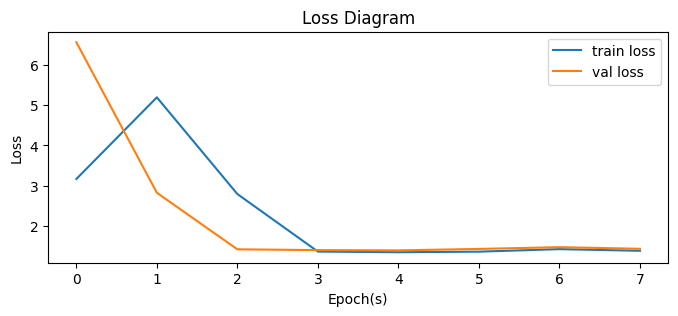

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

Model dapat disimpan dengan menggunakan perintah berikut.

In [ ]:
model.save('model_acc_89.h5')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = tf.keras.utils.load_img(path, target_size=(500, 500));
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  classes = model.predict(img_array/255);

  for i, class_ in enumerate(classes[0]):
      if class_ == classes[0].max():
          if i == 0:
              print("Sel Normal")
          elif i == 1:
              print("L-Sil")
          elif i == 2:
              print("H-Sil")
          else:
              print("Sel Koilocyt")

Saving koilocyt (70).png to koilocyt (70).png
1/1 [==============================] - 0s 227ms/step
H-Sil


Mari kita mencoba arsitektur CNN lain dengan proses konvolusi yang lebih besar/banyak.

In [ ]:
import tensorflow as tf
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten

model2 = Sequential()

# Conv Layer pertama
model2.add(Conv2D(255, (3,3), activation = 'relu', input_shape=(500,500, 3)))
model2.add(MaxPooling2D(2,2))

# Conv Layer kedua
model2.add(Conv2D(128, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(2,2))

# Conv Layer ketiga
model2.add(Conv2D(72, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(2,2))

# Conv Layer keempat
model2.add(Conv2D(36, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(2,2))

# Conv Layer kelima
model2.add(Conv2D(36, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(2,2))

# Flatten
model2.add(Flatten())

# Fully Connected Layer
model2.add(Dense(512, activation='relu'))
model2.add(Dense(4, activation='softmax'))

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 498, 498, 255)     7140      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 249, 249, 255)     0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 247, 247, 128)     293888    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 123, 123, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 121, 121, 72)      83016     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 60, 60, 72)       

In [ ]:
from tensorflow.keras.metrics import Recall, Precision
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= [Recall(), Precision(), "accuracy"]
)

In [ ]:
history2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=10,
    verbose=1
)

Epoch 1/100
10/10 [==============================] - 22s 1s/step - loss: 1.5084 - recall_1: 0.0188 - precision_1: 0.1875 - accuracy: 0.1437 - val_loss: 1.3896 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_accuracy: 0.2500
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 1.3890 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - accuracy: 0.2500 - val_loss: 1.4070 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_accuracy: 0.2500
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 1.3911 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - accuracy: 0.2937 - val_loss: 1.3879 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_accuracy: 0.2500
Epoch 4/100
10/10 [==============================] - 13s 1s/step - loss: 1.3906 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - accuracy: 0.2313 - val_loss: 1.3886 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_accuracy: 0.2500
Epoch 5/100
10/10 [=

Dapat dilihat dengan pemilihan arsitektur yang tepat kita bisa mendapatkan nilai evaluasi yang signifikan.

In [ ]:
model2.evaluate(train_generator)

20/20 [==============================] - 21s 1s/step - loss: 0.7378 - recall_1: 0.4469 - precision_1: 0.7688 - accuracy: 0.6406


[0.7378219962120056, 0.4468750059604645, 0.7688171863555908, 0.640625]

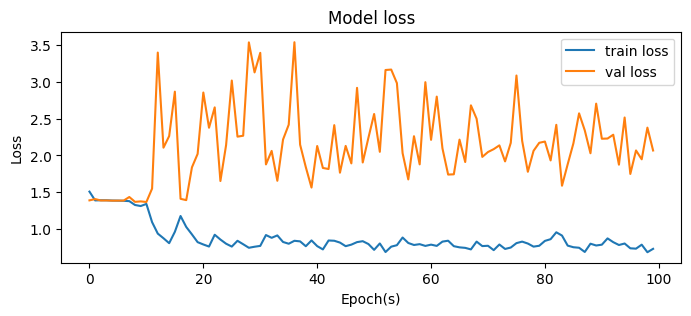

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history2.epoch, history2.history['loss'])
plt.plot(history2.epoch, history2.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Model loss')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

AttributeError: ignored

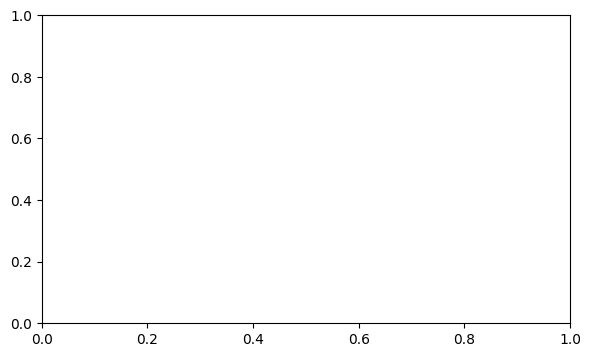

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history2.history2['accuracy'],color='r')
plt.plot(history2.history['val_accuracy'],color='b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history2.history['loss'],color='b')
plt.plot(history2.history['val_loss'],color='r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper right')

In [ ]:
import tensorflow as tf
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten

model3 = Sequential()

# Conv Layer pertama
model3.add(Conv2D(255, (3,3), activation = 'relu', input_shape=(500,500, 3)))
model3.add(MaxPooling2D(2,2))

# Conv Layer kedua
model3.add(Conv2D(128, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))

# Conv Layer ketiga
model3.add(Conv2D(128, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))

# Conv Layer keempat
model3.add(Conv2D(128, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))

# Conv Layer kelima
model3.add(Conv2D(128, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))

# Flatten
model3.add(Flatten())

# Fully Connected Layer
model3.add(Dense(512, activation='relu'))
model3.add(Dense(4, activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 498, 498, 255)     7140      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 249, 249, 255)     0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 247, 247, 128)     293888    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 123, 123, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 121, 121, 128)     147584    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 60, 60, 128)      

In [ ]:
model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= [Recall(), Precision(), "accuracy"]
)

In [ ]:
history3 = model3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=10,
    verbose=1
)

Epoch 1/100
10/10 [==============================] - 21s 2s/step - loss: 1.8398 - recall_3: 0.0312 - precision_3: 0.3125 - accuracy: 0.2313 - val_loss: 1.3874 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_accuracy: 0.2500
Epoch 2/100
10/10 [==============================] - 15s 2s/step - loss: 1.3872 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - accuracy: 0.2812 - val_loss: 1.3946 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_accuracy: 0.2500
Epoch 3/100
10/10 [==============================] - 16s 2s/step - loss: 1.3898 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - accuracy: 0.2625 - val_loss: 1.3867 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_accuracy: 0.2500
Epoch 4/100
10/10 [==============================] - 16s 2s/step - loss: 1.3851 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - accuracy: 0.2812 - val_loss: 1.3918 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_accuracy: 0.2500
Epoch 5/100
10/10 [=

In [ ]:
model3.evaluate(train_generator)

20/20 [==============================] - 26s 1s/step - loss: 0.7200 - recall_3: 0.4344 - precision_3: 0.8129 - accuracy: 0.6656


[0.7200230360031128,
 0.43437498807907104,
 0.8128654956817627,
 0.6656249761581421]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Model loss')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

In [ ]:
import tensorflow as tf
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten

model4 = Sequential()

# Conv Layer pertama
model4.add(Conv2D(255, (3,3), activation = 'relu', input_shape=(500,500, 3)))
model4.add(MaxPooling2D(2,2))

# Conv Layer kedua
model4.add(Conv2D(255, (3,3), activation = 'relu'))
model4.add(MaxPooling2D(2,2))

# Conv Layer ketiga
model4.add(Conv2D(255, (3,3), activation = 'relu'))
model4.add(MaxPooling2D(2,2))

# Conv Layer keempat
model4.add(Conv2D(255, (3,3), activation = 'relu'))
model4.add(MaxPooling2D(2,2))

# Conv Layer kelima
model4.add(Conv2D(255, (3,3), activation = 'relu'))
model4.add(MaxPooling2D(2,2))

# Flatten
model4.add(Flatten())

# Fully Connected Layer
model4.add(Dense(512, activation='relu'))
model4.add(Dense(4, activation='softmax'))

In [ ]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 498, 498, 255)     7140      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 249, 249, 255)     0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 247, 247, 255)     585480    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 123, 123, 255)     0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 121, 121, 255)     585480    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 60, 60, 255)      

In [ ]:
from tensorflow.keras.metrics import Recall, Precision
model4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= [Recall(), Precision(), "accuracy"]
)

In [ ]:
history4 = model4.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=10,
    verbose=1
)

NameError: ignored

In [ ]:
model3.evaluate(train_generator)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history4.epoch, history4.history['loss'])
plt.plot(history4.epoch, history4.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

New

In [ ]:
!pip install gdown

In [ ]:
# import gdown

# file_id = "1-bfrFLD5lKPGvy3eCjjUvjLMVYRFwgKV"  # Replace this with your file's ID
# output_file = "PapSmear.zip"  # Replace "data_file.ext" with the desired output filename and extension

# gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1-bfrFLD5lKPGvy3eCjjUvjLMVYRFwgKV
To: /content/PapSmear.zip
100%|██████████| 438M/438M [00:07<00:00, 61.0MB/s]


'PapSmear.zip'

In [ ]:
# import zipfile
# with zipfile.ZipFile("/content/PapSmear.zip", 'r') as zip_ref:
#     zip_ref.extractall("./")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Semua gambar (pixelnya) di rescale menjadi rentang 0-1
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
#test_datagen = ImageDataGenerator(rescale=1/255)

# Proses load data train
train_generator = train_datagen.flow_from_directory(
        '/content/PapSmear/train update',  # Source dari data train
        classes = ['Sel Normal', 'L-Sil','H-Sil','Sel Koilocyt'],
        target_size=(512, 512),  # Semua gambar akan diresize menjadi 512x512
        batch_size=16)

# Proses load data validation
validation_generator = validation_datagen.flow_from_directory(
        '/content/PapSmear/valid',  # Source dari data validation
        classes = ['Sel Normal', 'L-Sil','H-Sil','Sel Koilocyt'],
        target_size=(512, 512),  # Semua gambar akan diresize menjadi 512x512
        batch_size=16,
        shuffle=False)

# Proses load data test
# test_generator = test_datagen.flow_from_directory(
#         '/content/dataset_food/test',  # Source dari data test
#         classes = ['bakso', 'gado','gudeg','rendang','sate'],
#         target_size=(200, 200),  # Semua gambar akan diresize menjadi 200x200
#         batch_size=16,
#         shuffle=False)

Found 18917 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Accuracy
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
import tensorflow as tf
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten

model3 = Sequential()

# Conv Layer pertama
model3.add(Conv2D(255, (3,3), activation = 'relu', input_shape=(512,512, 3)))
model3.add(MaxPooling2D(2,2))

# Conv Layer kedua
model3.add(Conv2D(128, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))

# Conv Layer ketiga
model3.add(Conv2D(72, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))

# Conv Layer keempat
model3.add(Conv2D(36, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))

# Conv Layer kelima
model3.add(Conv2D(16, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))

# Flatten
model3.add(Flatten())

# Fully Connected Layer
model3.add(Dense(512, activation='relu'))
model3.add(Dense(4, activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 510, 510, 255)     7140      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 255, 255, 255)     0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 253, 253, 128)     293888    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 126, 126, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 72)      83016     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 72)       

In [ ]:
from tensorflow.keras.metrics import Recall, Precision
model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= [Recall(), Precision(), "accuracy"]
)

In [ ]:
history3 = model3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=10,
    verbose=1
)

Epoch 1/30
10/10 [==============================] - 11s 1s/step - loss: 0.5110 - recall_2: 0.5500 - precision_2: 0.9362 - accuracy: 0.7563 - val_loss: 2.8361 - val_recall_2: 0.2700 - val_precision_2: 0.3506 - val_accuracy: 0.3325
Epoch 2/30
10/10 [==============================] - 10s 1s/step - loss: 0.4985 - recall_2: 0.6500 - precision_2: 0.8254 - accuracy: 0.7250 - val_loss: 3.2674 - val_recall_2: 0.2900 - val_precision_2: 0.3648 - val_accuracy: 0.3425
Epoch 3/30
10/10 [==============================] - 10s 1s/step - loss: 0.6508 - recall_2: 0.5875 - precision_2: 0.7642 - accuracy: 0.6687 - val_loss: 2.2598 - val_recall_2: 0.3500 - val_precision_2: 0.4142 - val_accuracy: 0.4000
Epoch 4/30
10/10 [==============================] - 10s 1s/step - loss: 0.5560 - recall_2: 0.5750 - precision_2: 0.9109 - accuracy: 0.6875 - val_loss: 1.7701 - val_recall_2: 0.2425 - val_precision_2: 0.3896 - val_accuracy: 0.3700
Epoch 5/30
10/10 [==============================] - 10s 1s/step - loss: 0.5788 -

In [ ]:
model3.evaluate(train_generator)

1183/1183 [==============================] - 189s 159ms/step - loss: 0.6118 - recall_2: 0.5069 - precision_2: 0.9476 - accuracy: 0.6920


[0.6117625832557678,
 0.5068985819816589,
 0.9476233124732971,
 0.6920230388641357]

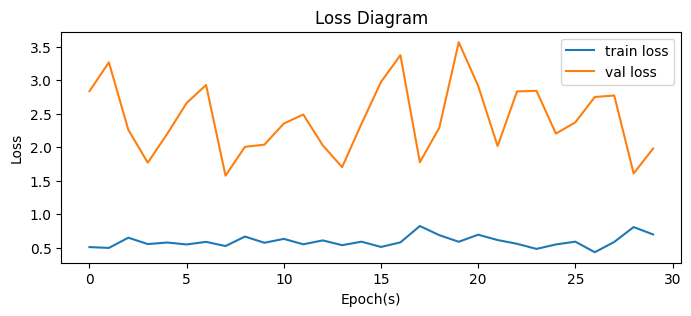

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history3.epoch, history3.history['loss'])
plt.plot(history3.epoch, history3.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()